## Creating datasets.

We will learn by doing while reading through chapter 10 of the pytorch book. The book focused far too much on the specific example and ignored introducing the abstract necessary components (other than the init, getitem and len) of efficiently constructing dataset to us. Our dataset structure will mimic the book's, while differ in detail, as there might be things that are simply not important to us. The following will be updated VERY FREQUENTLY, as this is very much a learning process. 

Due to the fact that the creation of raw feature can be time-consuming, we should offer chance of loading preexisting features, and make sure the feature creation is separate from the dataset. Due to the fact that the raw dataframe storing features can be unnecessarily large, we prob should not commit memory in dataset object to store the dataframe itself. Notice, there might be condition required upon the data, for instance, time_id and stock_id; and there might be different kinds of data, like simple tabular features, or timeseries like features. 

In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import copy

proj_mod is loaded later, when needed. 

Pivot will be our best friend. 

Following is an example of how pivot works. 

In [2]:
df = pd.DataFrame({'foo': ['one', 'one', 'one', 'two', 'two',

                           'two'],

                   'bar': ['A', 'B', 'C', 'A', 'B', 'C'],

                   'baz': [1, 2, 3, 4, 5, 6],

                   'zoo': ['x', 'y', np.nan, 'q', 'w', np.nan]})

In [3]:
df

,foo,bar,baz,zoo
0,one,A,1,x
1,one,B,2,y
2,one,C,3,NaN
3,two,A,4,q
4,two,B,5,w
5,two,C,6,NaN


In [4]:
df.pivot(index='foo', columns='bar', values=['baz', 'zoo'])

baz       zoo        
bar   A  B  C   A  B    C
foo                      
one   1  2  3   x  y  NaN
two   4  5  6   q  w  NaN

In [5]:
df_pv_dna=df.pivot(index='foo', columns='bar', values=['baz', 'zoo']).dropna(axis="columns")

In [6]:
df_pv_dna

baz       zoo   
bar   A  B  C   A  B
foo                 
one   1  2  3   x  y
two   4  5  6   q  w

In [7]:
df_1=pd.DataFrame({"foo":["one","two"],"new":["peepee","poopoo"],"bar":[np.nan,np.nan]})

In [8]:
df_1=df_1.pivot(index="foo",columns="bar",values=["new"])

In [9]:
df_1

,new
bar,NaN
foo,
one,peepee
two,poopoo


In [10]:
df_merge=pd.merge(df_pv_dna,df_1,on="foo")

In [11]:
df_merge

baz       zoo        new
bar   A  B  C   A  B     NaN
foo                         
one   1  2  3   x  y  peepee
two   4  5  6   q  w  poopoo

In [12]:
df_merge.loc[:,"zoo"]

bar,A,B
foo,,
one,x,y
two,q,w


In [13]:
df_merge.loc[:,"baz"].shape

(2, 3)

In [14]:
df_merge.dropna(axis="rows")

baz       zoo        new
bar   A  B  C   A  B     NaN
foo                         
one   1  2  3   x  y  peepee
two   4  5  6   q  w  poopoo

In [15]:
df_merge.shape

(2, 6)

In [16]:
df_merge[["baz"]].values.astype(np.float32)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [17]:
torch.tensor(df_merge[["baz"]].values.astype(np.float32), dtype=torch.float32)

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [ ]:
#06/27/25: Following is very much a work in progress. After debugging, we will copy this into training.py. 
#06/27/25: The subclass has been included in training.py, it can now be imported through there. 
#06/30/25: query_str filtering has been added to the version of the same function in training.py. It is then copied here for documentation. 
#07/02/25 added get_row_id method and numeric ordering option. Changes copied from traning.py
#Modified 07/02/25 fixed issue with error when tab_feature is None
class RVdataset(Dataset): 
    def __init__(self, query_str=None, query_val_list=None, time_id_list=None, stock_id_list=None, tab_features=None, ts_features=None, target="target", df_ts_feat=None, df_tab_feat=None, df_target=None, numeric=False):
        """
        Object in subclass of Dataset. 
        
        :param query_str: Defaulted to None, in which case, filter to dataset data will be applied through time_id_list and stock_id_list. Set to query string to apply filter to data included in dataset, when value is not None, the values of time_id_list and srock_id_list are practically ignored.         
        :param query_val_list: Defaulted to None. The list of variables that serves as reference for query string. This parameter is practically ignored when query_str is None. 
        :param time_id_list: Defaulted to None, in which case ALL time_id's will be included. A list (numpy array will NOT work) containing the time_id's of interest. If the value is not None, it is expected that "time_id" column (with values type int) is present in all input dataframes. 
        :param stock_id_list: Defaulted to None, in which case ALL stock_id's will be included. A list (numpy array will NOT work) containing the stock_id's of interst. If the value is not None, it is expected that "stock_id" column (with values type int) is present in all input dataframes. 
        :param tab_features: Defaulted to None, in which case NO feature will be included. A list containing the string of names of columns in df_tab_feat to be used as tabular features, for instance, the RV of current 10 mins bucket is a tabular feature. 
        :param ts_features: Defaulted to None, in which case NO feature will be included. A list containing the string of names of columns in df_ts_feat to be used as time series features, for instance, sub_int_RV in book_time created in data_processing_functions.ipynb. 
        :param target: Defaulted to "target". The string indicating how target is identified in column index of dataframe. 
        :param df_ts_feat: Defaulted to None. The dataframe containing the time series like features, must have "row_id" as identifier for rows and column "sub_int_num" as indicator of time series ordering. 
        :param df_tab_feat: Defaulted to None. The dataframe containing the tabluar features, must have "row_id" as identifier for rows. When df_target is not None, one should make sure there is no target in the df_tab_feat. 
        :param df_target: Defaulted to None, in which case, target will be searched in df_tab_feat instead and expects df_tab_feat to contain target column to be used as target. The dataframe containing the target stored in the target column, must have "row_id" to be used as identifier. 
        :param numeric: Defaulted to False. When set to true, RVdataset returns rows ordered numerically first by stock_id, and then by time_id 
        
        Object attributes: 
        
            self.features: The collection of features as a torch tensor. 
            self.target: The collection of targets as a torch tensor. 
            self.len: The length of the whole dataset object. 
            self.featuresplit: A dictionary in form of {feature name:length of feature, ...} to help distinguish different features in the feature torch tensor. The length of feature is included since some of the features are time series, while some are tabular. 
            
        Object methods: 

            self.__init__(): Initialize the object. 
            self.__getitem__(): Returns a feature and a target both as torch tensors, in this order, of a candidate. 
            self.__len__(): Returns the length of the dataset object. 
            get_row_id(): Returns the row_id for the feature and target returned
        """
        super().__init__()
        #If query_str is None: 
        if query_str is None: 
            #First case, no restriction on time and stock id 
            if ((time_id_list is None) & (stock_id_list is None)):
                #Import and pivot time series features 
                if not df_ts_feat is None:
                    df_ts_pv=df_ts_feat.pivot(index="row_id", columns="sub_int_num", values=ts_features).dropna(axis="columns")
                    #Import, add in the target, and pivot tabular features 
                if not df_tab_feat is None: 
                    df_tab_copy=df_tab_feat.copy(deep=True)
                if not df_target is None: 
                    if df_tab_feat is None: 
                        df_tab_copy=df_target
                        tab_features=[]
                    else: 
                        df_tab_copy=pd.merge(df_tab_copy,df_target,on="row_id")
                df_tab_copy.loc[:,"sub_int_num"]=np.nan 
                feat_tar=tab_features+[target]
                df_tab_pv=df_tab_copy.pivot(index="row_id", columns="sub_int_num", values=feat_tar)
                del df_tab_copy 
                #Create the full dataframe 
                df_whole_pv_dna=pd.merge(df_ts_pv,df_tab_pv,on="row_id").dropna(axis="rows")
                del df_ts_pv
                del df_tab_pv
                del feat_tar
            #Second case, only resticting stock id 
            elif (time_id_list is None):
                #Import and pivot time series features 
                if not df_ts_feat is None: 
                    df_ts_pv=df_ts_feat[df_ts_feat["stock_id"].isin(stock_id_list)].pivot(index="row_id", columns="sub_int_num", values=ts_features).dropna(axis="columns")
                    #Import, add in the target, and pivot tabular features 
                if not df_tab_feat is None: 
                    df_tab_copy=df_tab_feat[df_tab_feat["stock_id"].isin(stock_id_list)]
                if not df_target is None: 
                    if df_tab_feat is None: 
                        df_tab_copy=df_target[df_target["stock_id"].isin(stock_id_list)]
                        tab_features=[]
                    else: 
                        df_tab_copy=pd.merge(df_tab_copy,df_target[df_target["stock_id"].isin(stock_id_list)],on="row_id")
                df_tab_copy.loc[:,"sub_int_num"]=np.nan 
                feat_tar=tab_features+[target]
                df_tab_pv=df_tab_copy.pivot(index="row_id", columns="sub_int_num", values=feat_tar)
                del df_tab_copy 
                #Create the full dataframe 
                df_whole_pv_dna=pd.merge(df_ts_pv,df_tab_pv,on="row_id").dropna(axis="rows")
                del df_ts_pv
                del df_tab_pv
                del feat_tar
            #Thrid case, only restricting time id 
            elif (stock_id_list is None): 
                #Import and pivot time series features 
                if not df_ts_feat is None: 
                    df_ts_pv=df_ts_feat[df_ts_feat["time_id"].isin(time_id_list)].pivot(index="row_id", columns="sub_int_num", values=ts_features).dropna(axis="columns")
                    #Import, add in the target, and pivot tabular features 
                if not df_tab_feat is None: 
                    df_tab_copy=df_tab_feat[df_tab_feat["time_id"].isin(time_id_list)]
                if not df_target is None: 
                    if df_tab_feat is None: 
                        df_tab_copy=df_target[df_target["time_id"].isin(time_id_list)]
                        tab_features=[]
                    else: 
                        df_tab_copy=pd.merge(df_tab_copy,df_target[df_target["time_id"].isin(time_id_list)],on="row_id")
                df_tab_copy.loc[:,"sub_int_num"]=np.nan 
                feat_tar=tab_features+[target]
                df_tab_pv=df_tab_copy.pivot(index="row_id", columns="sub_int_num", values=feat_tar)
                del df_tab_copy 
                #Create the full dataframe 
                df_whole_pv_dna=pd.merge(df_ts_pv,df_tab_pv,on="row_id").dropna(axis="rows")
                del df_ts_pv
                del df_tab_pv
                del feat_tar
                # print(df_whole_pv_dna.columns)
            #Last, and forth, case, restricting both stock and time id
            else: 
                #Import and pivot time series features 
                if not df_ts_feat is None: 
                    df_ts_pv=df_ts_feat[(df_ts_feat["time_id"].isin(time_id_list))&(df_ts_feat["stock_id"].isin(stock_id_list))].pivot(index="row_id", columns="sub_int_num", values=ts_features).dropna(axis="columns")
                    #Import, add in the target, and pivot tabular features 
                if not df_tab_feat is None: 
                    df_tab_copy=df_tab_feat[(df_tab_feat["time_id"].isin(time_id_list))&(df_tab_feat["stock_id"].isin(stock_id_list))]
                if not df_target is None:
                    if df_tab_feat is None: 
                        df_tab_copy=df_target[(df_target["time_id"].isin(time_id_list))&(df_target["stock_id"].isin(stock_id_list))]
                        tab_features=[]
                    else: 
                        df_tab_copy=pd.merge(df_tab_copy,df_target[(df_target["time_id"].isin(time_id_list))&(df_target["stock_id"].isin(stock_id_list))],on="row_id")
                df_tab_copy.loc[:,"sub_int_num"]=np.nan 
                feat_tar=tab_features+[target]
                df_tab_pv=df_tab_copy.pivot(index="row_id", columns="sub_int_num", values=feat_tar)
                del df_tab_copy 
                #Create the full dataframe 
                df_whole_pv_dna=pd.merge(df_ts_pv,df_tab_pv,on="row_id").dropna(axis="rows")
                del df_ts_pv
                del df_tab_pv
                del feat_tar
        #If query_str is not None, apply query_str filtering and ignoring time_id_list and stock_id_list filtering. 
        else: 
            #Import and pivot time series features 
            if not df_ts_feat is None: 
                df_ts_pv=df_ts_feat.query(query_str).pivot(index="row_id", columns="sub_int_num", values=ts_features).dropna(axis="columns")
                #Import, add in the target, and pivot tabular features 
            if not df_tab_feat is None: 
                df_tab_copy=df_tab_feat.query(query_str)
            if not df_target is None: 
                if df_tab_feat is None: 
                    df_tab_copy=df_target.query(query_str)
                    tab_features=[]
                else: 
                    df_tab_copy=pd.merge(df_tab_copy,df_target.query(query_str),on="row_id")
            df_tab_copy.loc[:,"sub_int_num"]=np.nan 
            feat_tar=tab_features+[target]
            df_tab_pv=df_tab_copy.pivot(index="row_id", columns="sub_int_num", values=feat_tar)
            del df_tab_copy 
            #Create the full dataframe 
            df_whole_pv_dna=pd.merge(df_ts_pv,df_tab_pv,on="row_id").dropna(axis="rows")
            del df_ts_pv
            del df_tab_pv
            del feat_tar
        #Create object values 
        #The features, targets, and length
        all_feat=ts_features+tab_features

        # Reorders the rows of dataframe numerically (first by 'stock_id', then by 'time_id')
        if numeric==True:
            df_whole_pv_dna = df_whole_pv_dna.loc[
                df_whole_pv_dna.index.to_series()
                .apply(lambda s: tuple(map(int, s.split('-'))))
                .sort_values()
                .index
            ]
        
        # I added this to identify the returned item
        self.row_ids = df_whole_pv_dna.index.to_list()
        
        self.features=torch.tensor(df_whole_pv_dna.loc[:,all_feat].values.astype(np.float32),dtype=torch.float32)
        self.target=torch.tensor(df_whole_pv_dna.loc[:,target].values.astype(np.float32),dtype=torch.float32)
        self.len=df_whole_pv_dna.shape[0]
        #The record of feature positions 
        all_feat_len=[df_whole_pv_dna[feat].shape[1] for feat in all_feat]
        self.featuresplit=dict(zip(all_feat,all_feat_len))
        #Clean up
        del df_whole_pv_dna
        del all_feat 
        del all_feat_len
    def __getitem__(self, index):
        # return super().__getitem__(index)
        return self.features[index], self.target[index]
    def __len__(self):
        return self.len
     # I added this to identify the returned item   
    def get_row_id(self, index):
        return self.row_ids[index]     

## An example 

In [113]:
import importlib
import sys
import time

sys.path.append("../")

from proj_mod import data_processing, training
importlib.reload(data_processing); 
importlib.reload(training);

We load a precalculated timeseries like feature. 

In [20]:
# path_book="../raw_data/kaggle_ORVP/book_train.parquet"
# book_time=data_processing.create_timeseries(path_book,
#                                             dict_agg={"log_return":data_processing.rv},
#                                             dict_rename={"log_return":"sub_int_RV"})

# book_time.to_parquet("../processed_data/book_RV_ts_60_si.parquet")

In [21]:
book_time=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")

In [22]:
book_time

,time_id,sub_int_RV,sub_int_num,stock_id,row_id
0,5,0.000329,1,93,93-5
1,11,0.000191,1,93,93-11
2,16,0.000126,1,93,93-16
3,31,0.000205,1,93,93-31
4,62,0.000142,1,93,93-62
...,...,...,...,...,...
25735915,32686,0.000000,60,104,104-32686
25735916,32690,0.000000,60,104,104-32690
25735917,32712,0.000000,60,104,104-32712
25735918,32746,0.000000,60,104,104-32746


We add in a new (fake) time series feature for sake of example. 

In [23]:
book_time["fake_ts"]=1

In [24]:
book_time

,time_id,sub_int_RV,sub_int_num,stock_id,row_id,fake_ts
0,5,0.000329,1,93,93-5,1
1,11,0.000191,1,93,93-11,1
2,16,0.000126,1,93,93-16,1
3,31,0.000205,1,93,93-31,1
4,62,0.000142,1,93,93-62,1
...,...,...,...,...,...,...
25735915,32686,0.000000,60,104,104-32686,1
25735916,32690,0.000000,60,104,104-32690,1
25735917,32712,0.000000,60,104,104-32712,1
25735918,32746,0.000000,60,104,104-32746,1


We load in precalculated tabular features. 

In [25]:
# path_book="../raw_data/kaggle_ORVP/book_train.parquet"
# df_rv=data_processing.create_df_RV_by_row_id_parallel(path_book)

# df_rv.to_csv("../processed_data/RV_by_row_id.csv",index=False)

In [26]:
RV_train=pd.read_csv("../processed_data/RV_by_row_id.csv")

In [27]:
RV_train

,time_id,RV,row_id,stock_id
0,5,0.002185,93-5,93
1,11,0.001205,93-11,93
2,16,0.001461,93-16,93
3,31,0.001693,93-31,93
4,62,0.001296,93-62,93
...,...,...,...,...
428927,32751,0.002337,104-32751,104
428928,32753,0.001500,104-32753,104
428929,32758,0.002272,104-32758,104
428930,32763,0.001949,104-32763,104


We load in targets.

In [28]:
target_train=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")

In [29]:
target_train["row_id"]=target_train["stock_id"].astype(int).astype(str)+"-"+target_train["time_id"].astype(int).astype(str)

In [30]:
target_train

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62
...,...,...,...,...
428927,126,32751,0.003461,126-32751
428928,126,32753,0.003113,126-32753
428929,126,32758,0.004070,126-32758
428930,126,32763,0.003357,126-32763


Try out our RVdataset class. 

In [31]:
merged=pd.merge(RV_train,target_train,on="row_id")

In [32]:
merged["sub_int_num"]=np.nan

In [33]:
merged.pivot(index="row_id", columns="sub_int_num", values=["RV","target"])

,RV,target
sub_int_num,NaN,NaN
row_id,,
0-1000,0.001731,0.001348
0-10000,0.002863,0.001805
0-10005,0.008673,0.007544
0-10017,0.014300,0.011218
0-10030,0.002503,0.002854
...,...,...
99-9972,0.001629,0.001768
99-9973,0.009243,0.009511


For the sake of clarity, let us see what what the time series that we are feeding are:

In [34]:
book_time_series=book_time.pivot(index="row_id", columns="sub_int_num", values=["sub_int_RV","fake_ts"])
book_time_series

sub_int_RV                                                        \
sub_int_num         1         2         3         4         5             6    
row_id                                                                         
0-1000        0.000341  0.000000  0.000023  0.000000  0.000170  3.818799e-07   
0-10000       0.000290  0.000191  0.000087  0.000193  0.000241  3.154886e-04   
0-10005       0.000000  0.000000  0.001554  0.002177  0.002303  4.375100e-04   
0-10017       0.000142  0.000142  0.001464  0.001086  0.000068  6.771948e-05   
0-10030       0.000327  0.000058  0.000293  0.000842  0.000120  2.586782e-04   
...                ...       ...       ...       ...       ...           ...   
99-9972       0.000197  0.000181  0.000171  0.000172  0.000369  2.503467e-04   
99-9973       0.000821  0.000346  0.000691  0.001591  0.000863  9.650211e-04   
99-9976       0.000569  0.001101  0.001002  0.000430  0.000797  7.203531e-04   
99-9988       0.000040  0.000069  0.000123  0.000056  0.000016  1.957402e-04   
99-9993       0.000249  0.000179  0.000155  0.000025  0.000325  1.798617e-04   

                                                     ... fake_ts            \
sub_int_num        7         8         9         10  ...      51   52   53   
row_id                                               ...                     
0-1000       0.000089  0.000552  0.000012  0.000000  ...     1.0  1.0  1.0   
0-10000      0.000000  0.000247  0.000265  0.000000  ...     1.0  1.0  1.0   
0-10005      0.000617  0.001199  0.002306  0.001215  ...     1.0  1.0  1.0   
0-10017      0.000899  0.000064  0.000593  0.000451  ...     1.0  1.0  1.0   
0-10030      0.000221  0.000436  0.000099  0.000008  ...     1.0  1.0  1.0   
...               ...       ...       ...       ...  ...     ...  ...  ...   
99-9972      0.000349  0.000356  0.000390  0.000050  ...     1.0  1.0  1.0   
99-9973      0.000504  0.001925  0.000641  0.000382  ...     1.0  1.0  1.0   
99-9976      0.000586  0.000538  0.000570  0.000781  ...     1.0  1.0  1.0   
99-9988      0.000071  0.000095  0.000063  0.000030  ...     1.0  1.0  1.0   
99-9993      0.000080  0.000125  0.000126  0.000205  ...     1.0  1.0  1.0   

                                                
sub_int_num   54   55   56   57   58   59   60  
row_id                                          
0-1000       1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-10000      1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-10005      1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-10017      1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-10030      1.0  1.0  1.0  1.0  1.0  1.0  1.0  
...          ...  ...  ...  ...  ...  ...  ...  
99-9972      1.0  1.0  1.0  1.0  1.0  1.0  1.0  
99-9973      1.0  1.0  1.0  1.0  1.0  1.0  1.0  
99-9976      1.0  1.0  1.0  1.0  1.0  1.0  1.0  
99-9988      1.0  1.0  1.0  1.0  1.0  1.0  1.0  
99-9993      1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[428932 rows x 120 columns]

In [35]:
start_time = time.time()
RVds_ex=training.RVdataset(tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)
end_time = time.time()
print("Elapsed time: "+str(end_time-start_time)+" s")

Elapsed time: 5.00359845161438 s


Below is an example.

A call of getitem. 

In [36]:
RVds_ex.__getitem__(4)

(tensor([3.2661e-04, 5.8427e-05, 2.9315e-04, 8.4226e-04, 1.2050e-04, 2.5868e-04,
         2.2062e-04, 4.3564e-04, 9.8631e-05, 8.2075e-06, 2.7232e-04, 2.8753e-04,
         4.8274e-05, 0.0000e+00, 3.0392e-04, 2.3053e-04, 1.2232e-04, 3.3850e-04,
         6.8357e-05, 2.2303e-04, 1.3206e-05, 7.2208e-05, 1.1345e-04, 1.0250e-04,
         0.0000e+00, 4.8641e-05, 2.1731e-04, 1.6389e-04, 2.5918e-04, 6.7904e-04,
         1.1775e-04, 3.9567e-05, 2.9634e-05, 2.5930e-06, 8.1493e-05, 2.2103e-04,
         4.7025e-05, 0.0000e+00, 0.0000e+00, 5.8709e-04, 2.5899e-04, 5.1617e-05,
         4.0078e-04, 0.0000e+00, 4.1598e-04, 6.6761e-05, 4.0098e-04, 6.6177e-04,
         4.8521e-05, 1.0140e-03, 4.0974e-04, 4.3699e-04, 4.4433e-06, 2.1480e-04,
         4.5733e-04, 1.8328e-04, 4.8425e-04, 0.0000e+00, 7.5569e-04, 4.5666e-06,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e

which, as expected, corresponds to 'row_id':

In [37]:
RVds_ex.get_row_id(4)

'0-10030'

A call of len. 

In [38]:
RVds_ex.len

428932

In [39]:
RVds_ex.__len__()

428932

A call of featuresplit that indicates name of each feature and their length. 

In [40]:
RVds_ex.featuresplit

{'sub_int_RV': 60, 'fake_ts': 60, 'RV': 1}

In [41]:
del RVds_ex

Example with restriction on time id.

In [42]:
# # This was necessary for the older version of create_df_RV_by_row_id_parallel but it is no longer needed
# RV_train["time_id"]=RV_train["row_id"].apply(lambda x: int(x.split("-")[1]))

In [43]:
RV_train

,time_id,RV,row_id,stock_id
0,5,0.002185,93-5,93
1,11,0.001205,93-11,93
2,16,0.001461,93-16,93
3,31,0.001693,93-31,93
4,62,0.001296,93-62,93
...,...,...,...,...
428927,32751,0.002337,104-32751,104
428928,32753,0.001500,104-32753,104
428929,32758,0.002272,104-32758,104
428930,32763,0.001949,104-32763,104


In [44]:
RVds_ex_time_5=training.RVdataset(time_id_list=[5],tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)

For reference, restricting 'time_id' corresponds to the time series:

In [45]:
book_time_series[book_time_series.index.str.endswith("-5")]

sub_int_RV                                                        \
sub_int_num         1         2         3             4         5         6    
row_id                                                                         
0-5           0.000015  0.000010  0.001057  0.000000e+00  0.000898  0.000892   
1-5           0.000896  0.000751  0.001239  7.849253e-05  0.000653  0.000542   
10-5          0.000955  0.000437  0.000369  5.800923e-04  0.000948  0.000383   
100-5         0.000449  0.000185  0.000710  3.775195e-04  0.000202  0.000178   
101-5         0.000770  0.000531  0.001344  9.113532e-04  0.000448  0.000918   
...                ...       ...       ...           ...       ...       ...   
95-5          0.000793  0.000599  0.000712  5.260765e-04  0.000459  0.000483   
96-5          0.000909  0.000990  0.000656  4.498068e-04  0.000418  0.000413   
97-5          0.001354  0.001488  0.001537  1.218591e-03  0.000974  0.000007   
98-5          0.000624  0.000563  0.000126  2.199559e-08  0.000126  0.000766   
99-5          0.000450  0.000411  0.000328  4.574270e-04  0.000292  0.000245   

                                                     ... fake_ts            \
sub_int_num        7         8         9         10  ...      51   52   53   
row_id                                               ...                     
0-5          0.000454  0.000991  0.000037  0.000037  ...     1.0  1.0  1.0   
1-5          0.001351  0.001098  0.000508  0.000208  ...     1.0  1.0  1.0   
10-5         0.000462  0.000282  0.000666  0.001039  ...     1.0  1.0  1.0   
100-5        0.000932  0.000847  0.000208  0.000606  ...     1.0  1.0  1.0   
101-5        0.000887  0.000906  0.000377  0.000449  ...     1.0  1.0  1.0   
...               ...       ...       ...       ...  ...     ...  ...  ...   
95-5         0.000668  0.000350  0.000613  0.000595  ...     1.0  1.0  1.0   
96-5         0.000601  0.000477  0.000340  0.000503  ...     1.0  1.0  1.0   
97-5         0.001519  0.000353  0.001214  0.000290  ...     1.0  1.0  1.0   
98-5         0.000077  0.000000  0.000106  0.000374  ...     1.0  1.0  1.0   
99-5         0.000327  0.000250  0.000298  0.000304  ...     1.0  1.0  1.0   

                                                
sub_int_num   54   55   56   57   58   59   60  
row_id                                          
0-5          1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1-5          1.0  1.0  1.0  1.0  1.0  1.0  1.0  
10-5         1.0  1.0  1.0  1.0  1.0  1.0  1.0  
100-5        1.0  1.0  1.0  1.0  1.0  1.0  1.0  
101-5        1.0  1.0  1.0  1.0  1.0  1.0  1.0  
...          ...  ...  ...  ...  ...  ...  ...  
95-5         1.0  1.0  1.0  1.0  1.0  1.0  1.0  
96-5         1.0  1.0  1.0  1.0  1.0  1.0  1.0  
97-5         1.0  1.0  1.0  1.0  1.0  1.0  1.0  
98-5         1.0  1.0  1.0  1.0  1.0  1.0  1.0  
99-5         1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[112 rows x 120 columns]

In [46]:
RVds_ex_time_5.__getitem__(4)

(tensor([7.7038e-04, 5.3138e-04, 1.3440e-03, 9.1135e-04, 4.4765e-04, 9.1784e-04,
         8.8692e-04, 9.0616e-04, 3.7711e-04, 4.4867e-04, 5.3515e-04, 6.7545e-04,
         2.4650e-04, 2.7703e-04, 4.0072e-04, 2.0567e-04, 6.9939e-04, 9.0572e-04,
         4.3743e-04, 7.2798e-04, 8.4018e-04, 6.3853e-04, 7.5240e-04, 9.0852e-04,
         9.1498e-04, 3.4042e-04, 8.5778e-04, 1.0039e-03, 9.9095e-04, 3.6204e-04,
         2.9131e-04, 5.5730e-04, 3.7659e-04, 5.5760e-04, 9.4463e-04, 8.3860e-04,
         3.5856e-04, 1.0829e-03, 6.1781e-04, 7.5135e-04, 6.1211e-04, 8.8482e-04,
         5.8375e-04, 5.1112e-04, 9.4039e-04, 3.4305e-04, 7.2259e-04, 7.0091e-04,
         7.2568e-04, 8.3795e-04, 5.4137e-04, 6.1901e-04, 5.1636e-04, 5.3329e-04,
         6.5183e-04, 6.2254e-04, 2.9034e-04, 5.8241e-04, 3.6534e-04, 6.3362e-04,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e

In [47]:
RVds_ex_time_5.get_row_id(4)

'101-5'

Same can be done with query_str. 

In [48]:
time_filter=[5]

In [49]:
RVds_ex_time_5=training.RVdataset(query_str="time_id.isin(@query_val_list[0])",query_val_list=[time_filter],tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)

In [50]:
RVds_ex_time_5.__getitem__(4)

(tensor([7.7038e-04, 5.3138e-04, 1.3440e-03, 9.1135e-04, 4.4765e-04, 9.1784e-04,
         8.8692e-04, 9.0616e-04, 3.7711e-04, 4.4867e-04, 5.3515e-04, 6.7545e-04,
         2.4650e-04, 2.7703e-04, 4.0072e-04, 2.0567e-04, 6.9939e-04, 9.0572e-04,
         4.3743e-04, 7.2798e-04, 8.4018e-04, 6.3853e-04, 7.5240e-04, 9.0852e-04,
         9.1498e-04, 3.4042e-04, 8.5778e-04, 1.0039e-03, 9.9095e-04, 3.6204e-04,
         2.9131e-04, 5.5730e-04, 3.7659e-04, 5.5760e-04, 9.4463e-04, 8.3860e-04,
         3.5856e-04, 1.0829e-03, 6.1781e-04, 7.5135e-04, 6.1211e-04, 8.8482e-04,
         5.8375e-04, 5.1112e-04, 9.4039e-04, 3.4305e-04, 7.2259e-04, 7.0091e-04,
         7.2568e-04, 8.3795e-04, 5.4137e-04, 6.1901e-04, 5.1636e-04, 5.3329e-04,
         6.5183e-04, 6.2254e-04, 2.9034e-04, 5.8241e-04, 3.6534e-04, 6.3362e-04,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e

In [51]:
RVds_ex_time_5.get_row_id(4)

'101-5'

In [52]:
RVds_ex_time_5.featuresplit

{'sub_int_RV': 60, 'fake_ts': 60, 'RV': 1}

In [53]:
del RVds_ex_time_5

Example with restriction on stock id. 

In [54]:
# # This was necessary for the older version of create_df_RV_by_row_id_parallel but it is no longer needed
# RV_train["stock_id"]=RV_train["row_id"].apply(lambda x: int(x.split("-")[0]))

In [55]:
RV_train

,time_id,RV,row_id,stock_id
0,5,0.002185,93-5,93
1,11,0.001205,93-11,93
2,16,0.001461,93-16,93
3,31,0.001693,93-31,93
4,62,0.001296,93-62,93
...,...,...,...,...
428927,32751,0.002337,104-32751,104
428928,32753,0.001500,104-32753,104
428929,32758,0.002272,104-32758,104
428930,32763,0.001949,104-32763,104


We are considering the time series:

In [56]:
book_time_series[book_time_series.index.str.startswith("0-")]

sub_int_RV                                          \
sub_int_num            1         2         3         4         5    
row_id                                                              
0-1000       3.408371e-04  0.000000  0.000023  0.000000  0.000170   
0-10000      2.896415e-04  0.000191  0.000087  0.000193  0.000241   
0-10005      0.000000e+00  0.000000  0.001554  0.002177  0.002303   
0-10017      1.417857e-04  0.000142  0.001464  0.001086  0.000068   
0-10030      3.266084e-04  0.000058  0.000293  0.000842  0.000120   
...                   ...       ...       ...       ...       ...   
0-9972       4.572334e-04  0.000322  0.000943  0.000917  0.000000   
0-9973       1.746614e-06  0.001150  0.000000  0.001008  0.002120   
0-9976       6.478307e-04  0.000374  0.000000  0.000211  0.000000   
0-9988       9.550173e-05  0.000436  0.000048  0.000034  0.000082   
0-9993       4.692188e-07  0.000080  0.000000  0.000000  0.000095   

                                                                   ...  \
sub_int_num            6         7         8         9         10  ...   
row_id                                                             ...   
0-1000       3.818799e-07  0.000089  0.000552  0.000012  0.000000  ...   
0-10000      3.154886e-04  0.000000  0.000247  0.000265  0.000000  ...   
0-10005      4.375100e-04  0.000617  0.001199  0.002306  0.001215  ...   
0-10017      6.771948e-05  0.000899  0.000064  0.000593  0.000451  ...   
0-10030      2.586782e-04  0.000221  0.000436  0.000099  0.000008  ...   
...                   ...       ...       ...       ...       ...  ...   
0-9972       8.065626e-04  0.000000  0.000459  0.000147  0.000700  ...   
0-9973       5.829298e-04  0.002084  0.002772  0.001251  0.001211  ...   
0-9976       2.110745e-04  0.000981  0.000347  0.001228  0.000704  ...   
0-9988       1.950489e-04  0.000100  0.000203  0.000000  0.000213  ...   
0-9993       3.780332e-04  0.000304  0.000754  0.000405  0.000453  ...   

            fake_ts                                               
sub_int_num      51   52   53   54   55   56   57   58   59   60  
row_id                                                            
0-1000          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-10000         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-10005         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-10017         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-10030         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
0-9972          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-9973          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-9976          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-9988          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-9993          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[3830 rows x 120 columns]

In [57]:
RVds_ex_stock_0=training.RVdataset(stock_id_list=[0],tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)

In [58]:
RVds_ex_stock_0.__getitem__(4)

(tensor([3.2661e-04, 5.8427e-05, 2.9315e-04, 8.4226e-04, 1.2050e-04, 2.5868e-04,
         2.2062e-04, 4.3564e-04, 9.8631e-05, 8.2075e-06, 2.7232e-04, 2.8753e-04,
         4.8274e-05, 0.0000e+00, 3.0392e-04, 2.3053e-04, 1.2232e-04, 3.3850e-04,
         6.8357e-05, 2.2303e-04, 1.3206e-05, 7.2208e-05, 1.1345e-04, 1.0250e-04,
         0.0000e+00, 4.8641e-05, 2.1731e-04, 1.6389e-04, 2.5918e-04, 6.7904e-04,
         1.1775e-04, 3.9567e-05, 2.9634e-05, 2.5930e-06, 8.1493e-05, 2.2103e-04,
         4.7025e-05, 0.0000e+00, 0.0000e+00, 5.8709e-04, 2.5899e-04, 5.1617e-05,
         4.0078e-04, 0.0000e+00, 4.1598e-04, 6.6761e-05, 4.0098e-04, 6.6177e-04,
         4.8521e-05, 1.0140e-03, 4.0974e-04, 4.3699e-04, 4.4433e-06, 2.1480e-04,
         4.5733e-04, 1.8328e-04, 4.8425e-04, 0.0000e+00, 7.5569e-04, 4.5666e-06,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e

In [59]:
RVds_ex_stock_0.get_row_id(4)

'0-10030'

Same can be done with query_str. 

In [60]:
stock_filter=[0]

In [61]:
RVds_ex_stock_0=training.RVdataset(query_str="stock_id.isin(@query_val_list[0])",query_val_list=[stock_filter],tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)

In [62]:
RVds_ex_stock_0.get_row_id(4)

'0-10030'

In [63]:
RVds_ex_stock_0.len

3830

In [64]:
del RVds_ex_stock_0

Example of restriction on both stock and time id. 

In [65]:
RVds_ex_99_9976=training.RVdataset(time_id_list=[9976],stock_id_list=[99],tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)

Same can be done with query string. 

In [66]:
time_filter=[9976]
stock_filter=[99]

This corresponds to the time series:

In [67]:
book_time_series[book_time_series.index=="99-9976"]

sub_int_RV                                                  \
sub_int_num         1         2         3        4         5        6    
row_id                                                                   
99-9976       0.000569  0.001101  0.001002  0.00043  0.000797  0.00072   

                                                    ... fake_ts            \
sub_int_num        7         8        9         10  ...      51   52   53   
row_id                                              ...                     
99-9976      0.000586  0.000538  0.00057  0.000781  ...     1.0  1.0  1.0   

                                                
sub_int_num   54   55   56   57   58   59   60  
row_id                                          
99-9976      1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[1 rows x 120 columns]

In [68]:
RVds_ex_99_9976=training.RVdataset(query_str="(time_id.isin(@query_val_list[0])) and (stock_id.isin(@query_val_list[1]))", query_val_list=[time_filter,stock_filter], tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)

In [69]:
RVds_ex_99_9976.len

1

In [70]:
RVds_ex_99_9976.__getitem__(0)

(tensor([5.6925e-04, 1.1008e-03, 1.0019e-03, 4.2974e-04, 7.9684e-04, 7.2035e-04,
         5.8556e-04, 5.3812e-04, 5.7036e-04, 7.8058e-04, 3.9738e-04, 1.0601e-03,
         1.0944e-03, 1.0036e-03, 8.7386e-04, 9.5511e-04, 1.4647e-03, 5.6439e-04,
         4.1067e-04, 3.0456e-04, 6.0856e-04, 1.2683e-03, 1.2870e-03, 8.8957e-04,
         1.1209e-03, 5.5891e-04, 1.1045e-03, 4.2227e-04, 1.9949e-04, 2.9590e-04,
         7.9062e-04, 5.3115e-04, 6.8449e-04, 2.5842e-04, 3.8569e-04, 4.5423e-04,
         8.1110e-04, 3.3316e-04, 8.2041e-04, 4.9715e-04, 2.4006e-04, 4.3567e-04,
         5.0682e-04, 4.4008e-04, 5.9190e-04, 7.3303e-04, 5.5099e-04, 5.8218e-04,
         2.9630e-04, 9.4950e-04, 5.0832e-04, 4.0556e-04, 6.6204e-04, 3.3828e-04,
         7.0986e-04, 1.7941e-04, 5.9467e-04, 1.5097e-04, 3.8849e-04, 4.0262e-04,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e

In [71]:
del RVds_ex_99_9976

## Additionally, there is now an option for RVdataset to return series in numeric ordering (by 'stock_id' then by 'time_id') instead of lexicographic, called numeric

Ordering numerically does not take any longer:

In [72]:
start_time = time.time()
RVds_ex_numeric=training.RVdataset(tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train,numeric=True)
end_time = time.time()
print("Elapsed time: "+str(end_time-start_time)+" s")

Elapsed time: 5.412079811096191 s


In [73]:
RVds_ex_numeric.__getitem__(-1)

(tensor([1.0201e-04, 1.2714e-04, 5.5607e-05, 2.8040e-04, 5.4263e-05, 6.4276e-05,
         0.0000e+00, 1.5727e-05, 1.2796e-05, 6.3929e-04, 6.2667e-04, 4.3089e-04,
         2.3086e-04, 3.2581e-04, 6.0816e-04, 4.6469e-04, 4.6813e-06, 4.6813e-06,
         2.3030e-04, 1.2084e-04, 0.0000e+00, 1.3929e-04, 1.2349e-04, 9.6089e-05,
         1.8161e-04, 3.8374e-05, 2.4130e-04, 3.6173e-04, 2.9816e-04, 3.1891e-04,
         4.2251e-05, 5.3122e-04, 5.3015e-04, 3.2288e-04, 9.4300e-05, 2.6349e-04,
         6.6929e-05, 1.4608e-04, 8.6844e-05, 2.4349e-04, 2.2893e-04, 0.0000e+00,
         2.5887e-04, 2.0902e-04, 3.2380e-04, 3.3393e-04, 4.5376e-04, 9.4398e-05,
         1.1069e-04, 3.5458e-04, 1.1839e-05, 0.0000e+00, 8.9196e-06, 0.0000e+00,
         1.3357e-04, 1.8335e-04, 0.0000e+00, 5.0151e-04, 2.6604e-04, 2.3197e-04,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e

In [74]:
RVds_ex_numeric.get_row_id(-1)

'126-32767'

which matches the row ordering in the dataframe of series ordered numerically by 'stock_id' and then by 'time_id':

In [75]:
book_time_series = book_time.pivot(index="row_id", columns="sub_int_num", values=["sub_int_RV","fake_ts"])
book_time_series.loc[
    book_time_series.index.to_series()
    .apply(lambda s: tuple(map(int, s.split('-'))))
    .sort_values()
    .index
]

sub_int_RV                                                        \
sub_int_num         1         2         3         4         5             6    
row_id                                                                         
0-5           0.000015  0.000010  0.001057  0.000000  0.000898  8.920534e-04   
0-11          0.000004  0.000224  0.000201  0.000000  0.000020  3.308809e-05   
0-16          0.000432  0.000064  0.000076  0.000667  0.000004  2.263478e-04   
0-31          0.000000  0.000011  0.000053  0.000020  0.000000  1.390428e-04   
0-62          0.000235  0.000271  0.000162  0.000001  0.000000  8.802035e-07   
...                ...       ...       ...       ...       ...           ...   
126-32751     0.000043  0.000049  0.000706  0.000189  0.000053  3.474834e-04   
126-32753     0.000298  0.000486  0.000246  0.000215  0.000277  2.938544e-04   
126-32758     0.000056  0.000056  0.000008  0.000002  0.000011  2.775028e-04   
126-32763     0.000422  0.000591  0.001016  0.000395  0.000257  2.119924e-04   
126-32767     0.000102  0.000127  0.000056  0.000280  0.000054  6.427582e-05   

                                                     ... fake_ts            \
sub_int_num        7         8         9         10  ...      51   52   53   
row_id                                               ...                     
0-5          0.000454  0.000991  0.000037  0.000037  ...     1.0  1.0  1.0   
0-11         0.000240  0.000018  0.000000  0.000000  ...     1.0  1.0  1.0   
0-16         0.000075  0.000177  0.000018  0.000129  ...     1.0  1.0  1.0   
0-31         0.000009  0.000009  0.000000  0.000301  ...     1.0  1.0  1.0   
0-62         0.000789  0.000391  0.000000  0.000208  ...     1.0  1.0  1.0   
...               ...       ...       ...       ...  ...     ...  ...  ...   
126-32751    0.000247  0.000172  0.000806  0.000161  ...     1.0  1.0  1.0   
126-32753    0.000097  0.000026  0.000000  0.000026  ...     1.0  1.0  1.0   
126-32758    0.000143  0.000283  0.000009  0.000443  ...     1.0  1.0  1.0   
126-32763    0.000592  0.000665  0.000100  0.000413  ...     1.0  1.0  1.0   
126-32767    0.000000  0.000016  0.000013  0.000639  ...     1.0  1.0  1.0   

                                                
sub_int_num   54   55   56   57   58   59   60  
row_id                                          
0-5          1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-11         1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-16         1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-31         1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0-62         1.0  1.0  1.0  1.0  1.0  1.0  1.0  
...          ...  ...  ...  ...  ...  ...  ...  
126-32751    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
126-32753    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
126-32758    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
126-32763    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
126-32767    1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[428932 rows x 120 columns]

In [76]:
del RVds_ex_numeric

## An example of creating validation and training dataset. (The dataframe book_time, RV_train (at least the version with time_id), and target_train are still needed). 

In [3]:
# book_time=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")
# book_time["fake_ts"]=1

# RV_train=pd.read_csv("../processed_data/RV_by_row_id.csv")

# target_train=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")
# target_train["row_id"]=target_train["stock_id"].astype(int).astype(str)+"-"+target_train["time_id"].astype(int).astype(str)

First, import the recovered ordered time id. 

In [4]:
recov_time_id=np.load("../processed_data/recovered_time_id_order.npy")

In [5]:
recov_time_id

array([ 4294, 31984, 31570, ..., 29316, 32195, 10890])

Then, use function to create the fold time series cross validation split. 

In [6]:
enum_tcv=data_processing.time_cross_val_split(list_time=recov_time_id,list_output=True)

In fold 0 :

Train set end at 10433 .

Test set start at 5676 end at 26678 .

In fold 1 :

Train set end at 26678 .

Test set start at 16479 end at 13594 .

In fold 2 :

Train set end at 13594 .

Test set start at 8662 end at 8117 .

In fold 3 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



We will only use the last fold as an example. 

In [31]:
n_fold=3
train_time_id=list(enum_tcv[n_fold][0])
val_time_id=list(enum_tcv[n_fold][1])

The time reordering doesn't seem to follow any pattern:

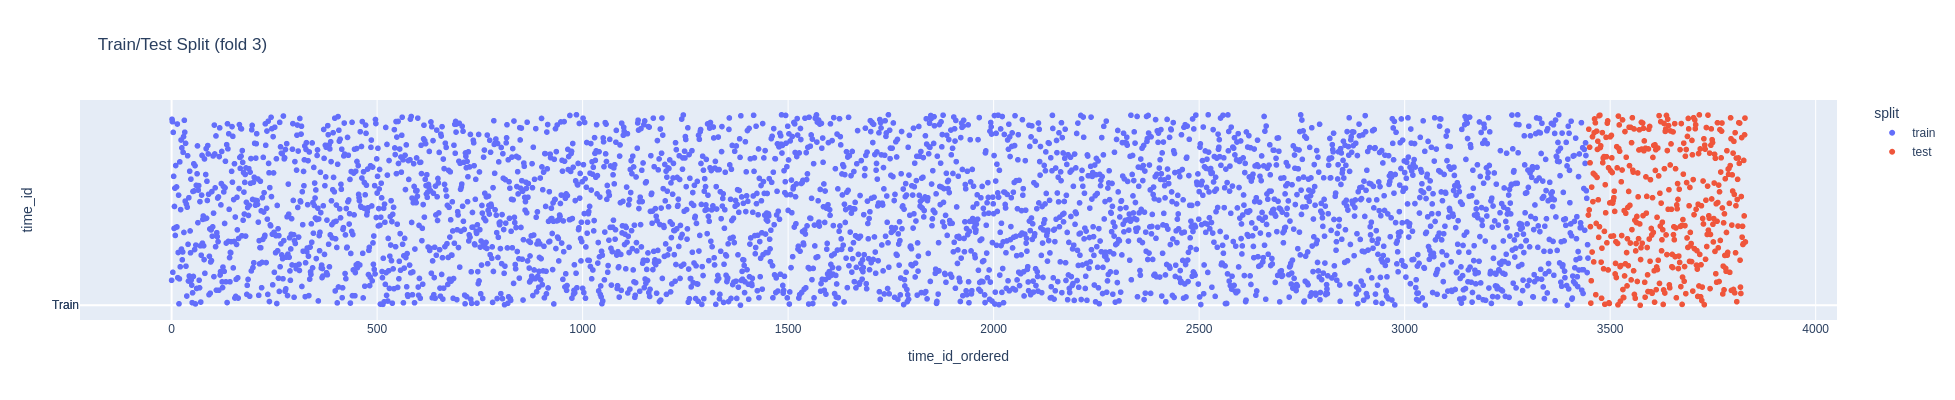

In [55]:
import numpy as np
import pandas as pd
import plotly.express as px


train_data = enum_tcv[3][0]
test_data = enum_tcv[3][1]

# Build dataframe
df = pd.DataFrame({
    'time_id_ordered': np.arange(len(train_data)+len(test_data)), 
    'time_id': np.concatenate([train_data, test_data]),
    'split': ['train'] * len(train_data) + ['test'] * len(test_data),
    'y': [0] * len(train_data) + [1] * len(test_data)
})

# Plotly scatter plot
fig = px.scatter(
    df, x="time_id_ordered", y="time_id", color="split",
    hover_data=["time_id", "split"],  # hover info
    title="Train/Test Split (fold "+str(n_fold)+")",
    height=400
)
fig.update_yaxes(tickvals=[0, 1], ticktext=["Train", "Test"])
fig.show()

del df

In [39]:
RV_train_dataset=training.RVdataset(time_id_list=train_time_id,tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)
RV_val_dataset=training.RVdataset(time_id_list=val_time_id,tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)

Same can be done with query_str. 

In [82]:
RV_train_dataset=training.RVdataset(query_str="time_id.isin(@query_val_list[0])",query_val_list=[train_time_id],tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)
RV_val_dataset=training.RVdataset(query_str="time_id.isin(@query_val_list[0])",query_val_list=[val_time_id],tab_features=["RV"],ts_features=["sub_int_RV","fake_ts"],df_ts_feat=book_time,df_tab_feat=RV_train,df_target=target_train)

In [83]:
RV_train_dataset.featuresplit

{'sub_int_RV': 60, 'fake_ts': 60, 'RV': 1}

In [84]:
RV_train_dataset.__len__()

386036

In [85]:
RV_val_dataset.__len__()

42896

Let us take a look at one of the time series for RV in the training set, and compared with the target RV. Note that because the target RV is given for every 'time_id' and the series we constructed has 60 time intervals per 'time_id', we need to divide by sqrt(60).

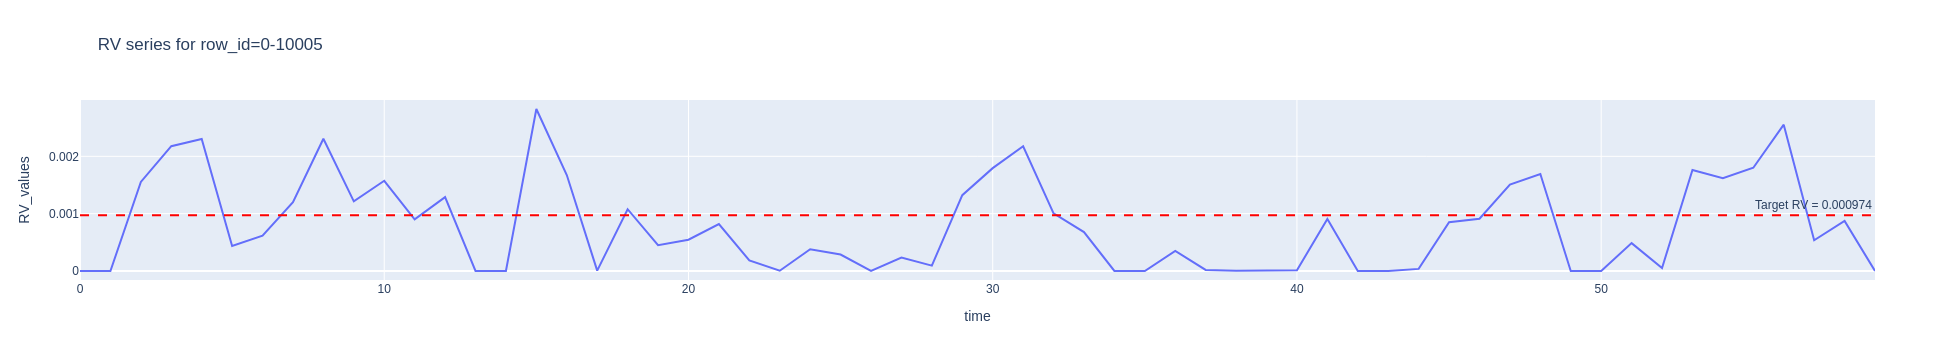

In [110]:
idx = 2
RV_values = RV_train_dataset.__getitem__(idx)[0][:60]
row_id = RV_train_dataset.get_row_id(idx)
target_RV_adjusted = target_train[target_train["row_id"]==row_id]['target'].item()/np.sqrt(60)

import torch
import plotly.express as px
import pandas as pd


time = torch.arange(60)

# Create DataFrame for Plotly
df = pd.DataFrame({
    'time': time.numpy(),
    'RV_values': RV_values.numpy(),
})

# Plot
fig = px.line(df, x='time', y='RV_values', title='RV series for row_id='+row_id)

fig.add_hline(
    y=target_RV_adjusted,
    line_dash="dash",
    line_color="red",
    annotation_text="Target RV = "+str(round(target_RV_adjusted,6)),
    annotation_position="top right"
)

fig.show()
del df

In [118]:
book_stock_0_10005=data_processing.book_for_stock("../raw_data/kaggle_ORVP/book_train.parquet",0,10005,create_para=True)
book_stock_0_10005

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return
0,10005,23,0.998435,1.000239,0.997108,1.000292,48,101,29,78,0,0.999016,-0.001117
1,10005,24,0.998435,1.000027,0.997108,1.000080,48,100,29,1,0,0.998951,-0.000065
2,10005,25,0.998435,1.000027,0.997108,1.000292,48,104,29,78,0,0.998937,-0.000014
3,10005,26,0.998435,0.999920,0.997108,0.999973,48,100,29,1,0,0.998916,-0.000021
4,10005,27,0.998435,0.999814,0.997108,0.999867,48,101,29,1,0,0.998879,-0.000037
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,10005,583,1.001141,1.003104,1.000557,1.003157,100,100,29,400,0,1.002123,0.000799
179,10005,584,1.001141,1.003104,1.000557,1.003157,100,100,29,300,0,1.002123,0.000000
180,10005,585,1.001141,1.003104,1.000557,1.003157,100,100,29,300,0,1.002123,0.000000
181,10005,587,1.001141,1.003157,1.000557,1.003900,102,100,29,200,0,1.002159,0.000036


We can compare with the realized volatility over a 10 s rolling window (which should have the same scaling, as there are 60 periods of 10s in 10 minutes):

In [131]:
start_time = pd.Timestamp("2000-01-01 00:00:00")
book_stock_0_10005['timestamp'] = start_time + pd.to_timedelta(book_stock_0_10005['seconds_in_bucket'], unit='s')
book_stock_0_10005 = book_stock_0_10005.set_index('timestamp').sort_index()


book_stock_0_10005['RV_10s_zero_mean'] = book_stock_0_10005['log_return'].rolling('10s', min_periods=1).apply(data_processing.rv, raw=True)

book_stock_0_10005['RV_10s'] = book_stock_0_10005['log_return'].rolling('10s', min_periods=1).std().fillna(0)
book_stock_0_10005

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return,RV_10s,RV_10s_zero_mean
timestamp,,,,,,,,,,,,,,,
2000-01-01 00:00:23,10005,23,0.998435,1.000239,0.997108,1.000292,48,101,29,78,0,0.999016,-0.001117,0.000000,0.001117
2000-01-01 00:00:24,10005,24,0.998435,1.000027,0.997108,1.000080,48,100,29,1,0,0.998951,-0.000065,0.000744,0.001119
2000-01-01 00:00:25,10005,25,0.998435,1.000027,0.997108,1.000292,48,104,29,78,0,0.998937,-0.000014,0.000623,0.001119
2000-01-01 00:00:26,10005,26,0.998435,0.999920,0.997108,0.999973,48,100,29,1,0,0.998916,-0.000021,0.000543,0.001120
2000-01-01 00:00:27,10005,27,0.998435,0.999814,0.997108,0.999867,48,101,29,1,0,0.998879,-0.000037,0.000485,0.001120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-01-01 00:09:43,10005,583,1.001141,1.003104,1.000557,1.003157,100,100,29,400,0,1.002123,0.000799,0.000461,0.000949
2000-01-01 00:09:44,10005,584,1.001141,1.003104,1.000557,1.003157,100,100,29,300,0,1.002123,0.000000,0.000408,0.000895
2000-01-01 00:09:45,10005,585,1.001141,1.003104,1.000557,1.003157,100,100,29,300,0,1.002123,0.000000,0.000371,0.000895


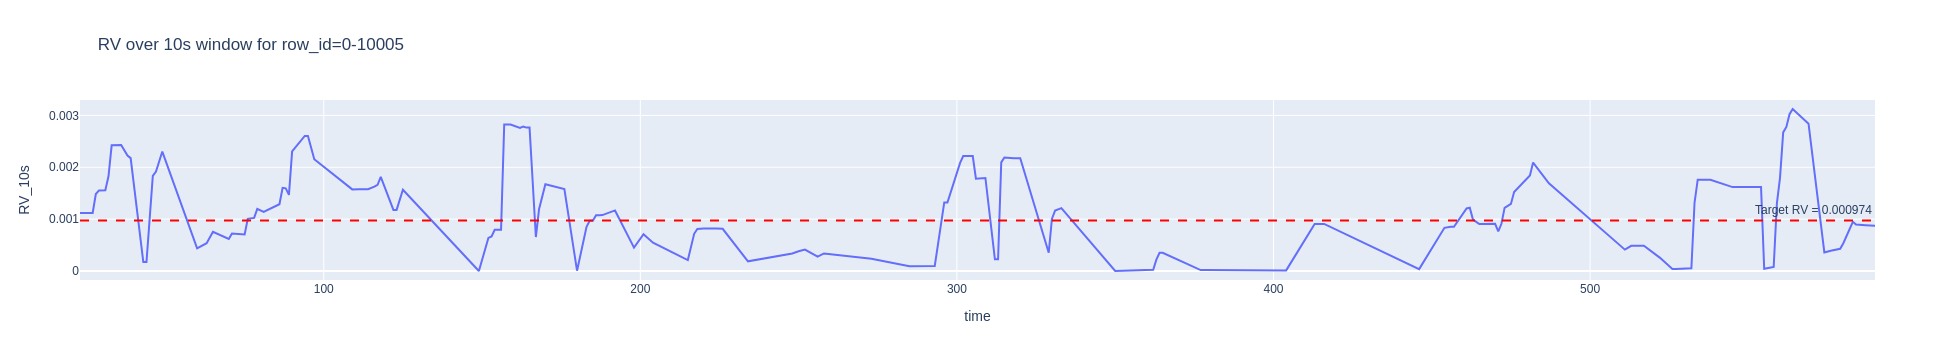

In [132]:
time = torch.arange(60)

# Create DataFrame for Plotly
df = pd.DataFrame({
    'time': book_stock_0_10005['seconds_in_bucket'],
    'RV_10s': book_stock_0_10005['RV_10s_zero_mean'],
})

# Plot
fig = px.line(df, x='time', y='RV_10s', title='RV over 10s window for row_id='+row_id)

fig.add_hline(
    y=target_RV_adjusted,
    line_dash="dash",
    line_color="red",
    annotation_text="Target RV = "+str(round(target_RV_adjusted,6)),
    annotation_position="top right"
)

fig.show()
del df

Always a good practice to delete object when finished. 

In [111]:
del RV_val_dataset
del RV_train_dataset